## Introduction to Natural Language Processing
[**CC-BY-NC-SA**](https://creativecommons.org/licenses/by-nc-sa/4.0/deed.en)<br/>
Prof. Dr. Annemarie Friedrich<br/>
Faculty of Applied Computer Science, University of Augsburg<br/>
Date: **SS 2025**

# 5. Logistic Regression

**Learning Goals:**<br/>
1. Represent text using distributional features​
2. Classify an instance using a linear classifier​
3. Describe how a logistic regression classifier works (for binary + multi-class classification)​
4. Evaluate a classifier using precision, recall, and F1

The aim of this notebook is to understand logistic regression using a concrete example.

Assume that our training set consists of three data points, two SPAM e-mails (red points) and one NO_SPAM e-mail (blue points).
We can treat this as a __binary__ classification setting: "Is a given new e-mail a SPAM mail?"




In [1]:
# Imports and helper functions
import math
import numpy as np
from numpy import arange # for ranges with decimal steps
from math import log
import matplotlib
from matplotlib import pyplot as plt # for plotting

### Training Data

Each training instance consists of a two-dimensional feature vector $x$, composed of $x_1$ and $x_2$.
In our lecture on Logistic Regression, the values of these features were the counts of some informative lemmas ("information" and "account").

For each instance, we also have a __one-hot encoding__ $y$ representing the class label, i.e., the first dimension corresponds to the first class ("NO_SPAM") and the second dimension corresponds to the second class ("SPAM").

In [2]:
train_data = [([2, 1], [0,1]),
              ([5,2], [0,1]),
              ([3, 4], [1,0])]
train_data_x = [l[0] for l in train_data]
train_data_y = [l[1] for l in train_data]
print("training data x:", train_data_x)
print("training data y:", train_data_y)

training data x: [[2, 1], [5, 2], [3, 4]]
training data y: [[0, 1], [0, 1], [1, 0]]


In [3]:
# Some helper functions and indices for plotting and inspecting results

# Given a one-hot encoded vector, return the class label as a string
# 0 means the first entry of the one-hot-encoded class label is 1 ==> [1, 0]
# 1 means the second entry of the one-hot-encoded class label is 1 ==> [0, 1]
idx2label = {0: "NO_SPAM", 1: "SPAM"}
idx2color = {0: "blue", 1: "red"} # we need this for plotting only

def get_label_string(one_hot_label):
  return idx2label[one_hot_label.index(1)]

def get_color_string(one_hot_label):
  return idx2color[one_hot_label.index(1)]

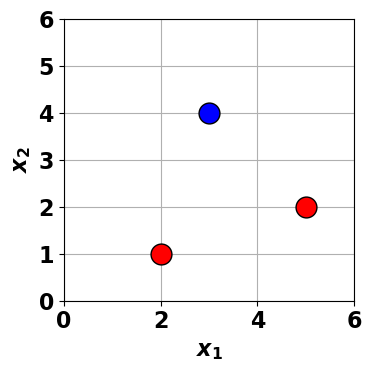

In [4]:
# Let's take a look at the training data.
# red = SPAM, blue = NO_SPAM

# Configure our plot
font = {'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = [4, 4]
plt.rcParams["figure.autolayout"] = True
plt.xlim(0, 6)
plt.ylim(0, 6)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.grid()

# Plot the training data points
for (x1,x2), label in train_data:
  labelstring = get_label_string(label)
  labelcolor = get_color_string(label)
  plt.plot(x1, x2, marker="o", markersize=15, markeredgecolor="black", markerfacecolor=labelcolor)

plt.show()

### Linear Classifier

Let's plot a possible decision boundary between the instances of our class.

The green line in the image below describes a boundary separating the feature space into two areas: anything below the line is classified as the NO_SPAM category, anything above (strictly speaking, above or exactly on) the line is classified as a SPAM e-mail.

The line can be described by the following function: $x_2 = 0.25 \cdot x_1 + 2$

Good explanation: https://en.wikipedia.org/wiki/Linear_classifier

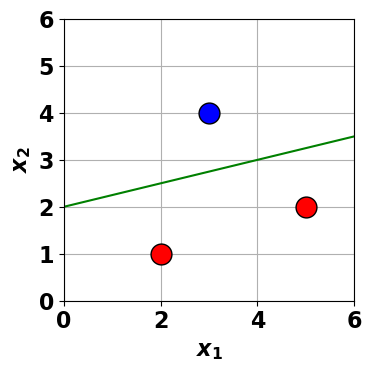

In [5]:
def decision_boundary(x1):
  # Returns the value of x2
  return 0.25*x1 + 2

# Configure our plot
plt.xlim(0, 6)
plt.ylim(0, 6)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.grid()

# Plot the training data points
for (x1,x2), label in train_data:
  labelstring = get_label_string(label)
  labelcolor = get_color_string(label)
  plt.plot(x1, x2, marker="o", markersize=15, markeredgecolor="black", markerfacecolor=labelcolor)

# classifier line (x-values chosen to match plot boundaries for x1)
# The first parameter of the plot function are the x-values, the second are the y-values.
plt.plot([0, 6], [decision_boundary(0), decision_boundary(6)], color="green")
plt.show()


Our decision boundary is defined as:

$x_2 = 0.25 * x_1 + 2$

Any data point that is below the line in our feature space will be classified as SPAM, anything else will be classified as NO_SPAM.

Logistic regression classifiers are __linear classifiers__ because they split the feature space into regions representing instances of one class each. If we had three features, the decision boundary would be a plane. If we had more than three features, the decision boundary would be a _hyperplane_ in our high-dimensional space (hard to imagine, just stick the to two- or three-dimensional example in your head).


Let's do some re-arrangements of our formula.

$x_2 < 0.25 \cdot x_1 + 2$ --> return SPAM, return NO_SPAM otherwise.

$0 < 0.25 \cdot x_1 -x_2 + 2$ --> return SPAM, return NO_SPAM otherwise.

In [6]:
# Classifier function, making use of the linear equation above
# Returns the predicted one-hot encoded label vector
def classify(x, w, b):
  x1, x2 = x[0], x[1]
  w1, w2 = w[0], w[1]
  if 0 < w1*x1 + w2*x2 + b:
    return [0,1]
  else: # w1*x1 + w2*x2 +b <= 0
    return [1,0]

# Let's classify our training data with this classifier
w = [0.25, -1]
b = 2
for x, label in train_data:
  prediction = classify(x, w, b)
  print(x, "predicted:", get_label_string(prediction), "| gold:", get_label_string(label))

[2, 1] predicted: SPAM | gold: SPAM
[5, 2] predicted: SPAM | gold: SPAM
[3, 4] predicted: NO_SPAM | gold: NO_SPAM


In [7]:
print("What if we had chosen the weights w for our function less cleverly?")
w = [2, -1]
b = 0
for x, label in train_data:
  prediction = classify(x, w, b)
  print(x, "predicted:", get_label_string(prediction), "| gold:", get_label_string(label))

What if we had chosen the weights w for our function less cleverly?
[2, 1] predicted: SPAM | gold: SPAM
[5, 2] predicted: SPAM | gold: SPAM
[3, 4] predicted: SPAM | gold: NO_SPAM


### Class Probabilities and the Sigmoid Function

Above, we have defined our classifier as follows:

$0 < 0.25 \cdot x_1 -x_2 + 2$ --> return SPAM, return NO_SPAM otherwise.

Let us call the right-hand side of this equation the _score_ $z$. The higher this score, the more sure our classifier is that the instance is really a SPAM e-mail. If $z$ is strongly negative, the classifier will be more _confident_ that the e-mail is NO_SPAM.

$z = 0.25 \cdot x_1 -x_2 + 2$

What are the values of $z$ for our training instances above?
Look at the plot and compare the distances to the decision boundary.


In [8]:
def z(x, w, b):
  x1, x2 = x[0], x[1]
  w1, w2 = w[0], w[1]
  return x1*w1 + x2*w2 + b

w = [0.25, -1]
b = 2
for x, label in train_data:
  print("x=", x, "  gold label: {:8s}".format(get_label_string(label)), " z=", z(x, w, b))

x= [2, 1]   gold label: SPAM      z= 1.5
x= [5, 2]   gold label: SPAM      z= 1.25
x= [3, 4]   gold label: NO_SPAM   z= -1.25


In [9]:
# Let's do this once again but use numpy for the calculations
def z(x, w, b):
  # numpy.dot computes the dot product between x and y
  return np.dot(x, w) + b

w = [0.25, -1]
b = 2
for x, label in train_data:
  print("x=", x, "  gold label: {:8s}".format(get_label_string(label)), " z=", z(x, w, b))

x= [2, 1]   gold label: SPAM      z= 1.5
x= [5, 2]   gold label: SPAM      z= 1.25
x= [3, 4]   gold label: NO_SPAM   z= -1.25


Now, we have one score per instance. If our binary classifier classifies the instances as belonging to the _positive class_, in our case SPAM, this score will be positive. If the score is negative, the instance will be classified into the _negative class_, NO_SPAM.
In order to create a probability value for these decisions, we can use the __sigmoid__ function, which looks like this:

$\displaystyle \sigma(z) = \frac{1}{1+e^{-z}}$

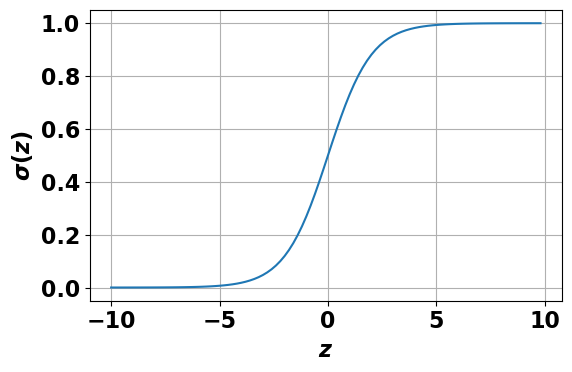

In [10]:
# in code ...
def sigmoid(z):
  # Sigmoid function
  return 1 / (1 + math.exp(-z))

plt.rcParams["figure.figsize"] = [6, 4]
x = np.arange(-10., 10., 0.2)
sig = [sigmoid(z) for z in x]
plt.plot(x,sig)
plt.grid()

plt.xlabel("$z$")
plt.ylabel("$\sigma(z)$")

plt.show()

If the score $z$ is exactly 0, the model does not know to which class the instance belongs. Similar to how we chose z>0 to classify into the positive class above, here, we make the decision to classify our instance as SPAM only if $\sigma(z) > 0.5$.

If $z$ is positive, $\sigma(z)$ will output a score greater than 0.5 but less than 1 (approaching 1 for high $z$).
If $z$ is negative, $\sigma(z)$ will output a score less than 0.5 but greater 0 (approaching 0 for very negative $z$).
Voilà! We just converted our $z$ scores into something that we can interpret as a probability.

Let us use this sigmoid-based classifier to classify our training data.

In [11]:
def get_prob(x, w, b):
  # Returns the probability that a point x belongs to the POSITIVE class
  return sigmoid(z(x, w, b))

def get_class(prob):
  """ Binary classifier: given a class probability, returns 1 if the instance
  is classifies as belonging to the positive class, and 0 otherwise.
  """
  if prob > 0.5:
    return [0, 1] # SPAM
  return [1, 0] # NO_SPAM

#w = np.array([-0.2, 0.5])
#b = -0.5
w = [0.25, -1]
b = 2

for x, label in train_data:
  x = np.array(x)
  prob = get_prob(x, w, b)
  predicted_label = get_label_string(get_class(prob))
  print(round(prob, 3), "| predicted:", predicted_label, "| gold:", get_label_string(label))

0.818 | predicted: SPAM | gold: SPAM
0.777 | predicted: SPAM | gold: SPAM
0.223 | predicted: NO_SPAM | gold: NO_SPAM


### Evaluation

As we can see in the plot above, our classifier defined by the green decision boundary does quite well, but not perfectly. How well does it do?
The code below defines a `test_set`, i.e., instances defined by their x-coordinates and a gold (true) label. Use this test set to evaluate our classifier.

❓ Compute overall __accuracy__, __precision__, __recall__ and __F1__ for the SPAM and NO_SPAM classes, and the overall __macro-average__ precision, recall, and F1 scores. You can use `numpy` to implement your solution, or just lists. _Self-control: Macro-average F1 (computed as the average of the per-class F1 scores) should be 85.8%)_.

❓[`scikit-learn`](https://scikit-learn.org/stable/modules/model_evaluation.html) provides implementations for a wide range of evaluation metrics. Use its `classification_report` function and compare the results you obtained. Do they match up? Research: What is the __support__ for each class? To which of your scores does _micro-average precision/recall_ correspond?

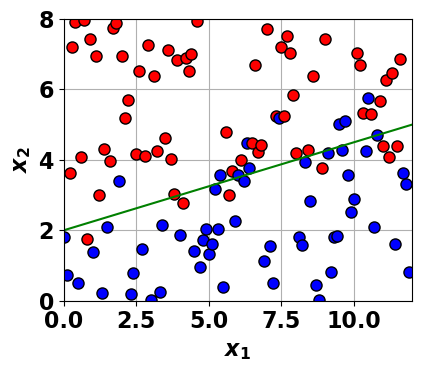

In [ ]:
plt.rcParams["figure.figsize"] = [4.5, 4]
plt.rcParams["figure.autolayout"] = True
plt.xlim(0, 12)
plt.ylim(0, 8)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.grid()

def get_class(x, w, b):
  """ Binary classifier: given a class probability, returns 1 if the instance
  is classified as belonging to the positive class, and 0 otherwise.
  """
  prob = get_prob(x, w, b)
  if prob > 0.5:
    return [1, 0] # SPAM
  return [0, 1] # NO_SPAM

# test_data
x = [(0.0, 1.8031414310013778), (0.1, 0.7258266946966128), (0.2, 3.620890138280598), (0.30000000000000004, 7.208262407211244), (0.4, 7.9015496552923), (0.5, 0.5039830954870919), (0.6000000000000001, 4.06797329635813), (0.7000000000000001, 7.983453959845199), (0.8, 1.744624664590675), (0.9, 7.4386489533843765), (1.0, 1.3879150006932264), (1.1, 6.961529929419906), (1.2000000000000002, 3.009016171321684), (1.3, 0.21577209105583162), (1.4000000000000001, 4.314408110027064), (1.5, 2.0870358021132507), (1.6, 3.9694403318500404), (1.7000000000000002, 7.73404269939958), (1.8, 7.872276447252742), (1.9000000000000001, 3.4102830261899753), (2.0, 6.950391881664507), (2.1, 5.196834496197658), (2.2, 5.687574086560304), (2.3000000000000003, 0.18441127782233924), (2.4000000000000004, 0.7917129959244376), (2.5, 4.159116171770697), (2.6, 6.5103625862990935), (2.7, 1.4810120986723954), (2.8000000000000003, 4.099397342943209), (2.9000000000000004, 7.262115492251488), (3.0, 0.02603785021018723), (3.1, 6.371919856494345), (3.2, 4.247548334633407), (3.3000000000000003, 0.23460348973473089), (3.4000000000000004, 2.1521824243505705), (3.5, 4.609666245973957), (3.6, 7.133737762183526), (3.7, 4.011814048907767), (3.8000000000000003, 3.027436275449843), (3.9000000000000004, 6.842656283399255), (4.0, 1.8583332676912194), (4.1000000000000005, 2.7613600471652333), (4.2, 6.884602483957005), (4.3, 6.515668720680005), (4.4, 7.017996394694035), (4.5, 1.4219275884176135), (4.6000000000000005, 7.9344971212904865), (4.7, 0.9541664439429756), (4.800000000000001, 1.7302799854523538), (4.9, 2.0477059973254637), (5.0, 1.3136691193536993), (5.1000000000000005, 1.619555584912522), (5.2, 3.1699717485192718), (5.300000000000001, 2.0275549840371596), (5.4, 3.580062457275159), (5.5, 0.3961008520064677), (5.6000000000000005, 4.791811268471962), (5.7, 2.988877217484877), (5.800000000000001, 3.6916920399266697), (5.9, 2.2629700234129473), (6.0, 3.5568458181048817), (6.1000000000000005, 4.0072054410668345), (6.2, 3.397709154949051), (6.300000000000001, 4.479354923658485), (6.4, 3.779218269713576), (6.5, 4.49260035500632), (6.6000000000000005, 6.704878718129064), (6.7, 4.232842669175323), (6.800000000000001, 4.435590537868435), (6.9, 1.1194463140220652), (7.0, 7.703459356046112), (7.1000000000000005, 1.5600507580820313), (7.2, 0.5141787298535432), (7.300000000000001, 5.249958001107477), (7.4, 5.17737850872501), (7.5, 7.204197478827536), (7.6000000000000005, 5.233859061238796), (7.7, 7.504534034744136), (7.800000000000001, 7.040063987125225), (7.9, 5.853698241099453), (8.0, 4.189018630079597), (8.1, 1.8027090127187035), (8.200000000000001, 1.590556510834884), (8.3, 3.9285267451812667), (8.4, 4.265836585226139), (8.5, 2.8188896520913715), (8.6, 6.368823358544846), (8.700000000000001, 0.43720731136563984), (8.8, 0.009027105974214855), (8.9, 3.775660724199586), (9.0, 7.421673619888216), (9.1, 4.182462255005673), (9.200000000000001, 0.820464795751441), (9.3, 1.8230699838875157), (9.4, 1.8417473124953103), (9.5, 5.013064050400255), (9.600000000000001, 4.276477687095192), (9.700000000000001, 5.092134219128303), (9.8, 3.559693015164285), (9.9, 2.508221822640583), (10.0, 2.8774956261454916), (10.100000000000001, 7.031656156170564), (10.200000000000001, 6.684085289318193), (10.3, 5.338287880115494), (10.4, 4.250488260478787), (10.5, 5.748030038719616), (10.600000000000001, 5.311713013402326), (10.700000000000001, 2.0875891800145263), (10.8, 4.718231486204861), (10.9, 5.664660455878861), (11.0, 4.384353140466228), (11.100000000000001, 6.270162437068839), (11.200000000000001, 4.0677924506280885), (11.3, 6.469165566689657), (11.4, 1.6214033214768877), (11.5, 4.406764425333195), (11.600000000000001, 6.877571253785525), (11.700000000000001, 3.6222972571776255), (11.8, 3.3030920081083837), (11.9, 0.8015332684594343)]
labels = [[1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0]]
test_data = list(zip(x, labels))

# Plot the test data points
for (x1,x2), label in test_data:
  labelstring = get_label_string(label)
  labelcolor = get_color_string(label)
  plt.plot(x1, x2, marker="o", markersize=8, markeredgecolor="black", markerfacecolor=labelcolor)

# classifier line (x-values chosen to match plot boundaries for x1)
# The first parameter of the plot function are the x-values, the second are the y-values.
plt.plot([0, 12], [decision_boundary(0), decision_boundary(12)], color="green")
plt.show()

In [34]:
# Your code here

# Accumulator Variables for TruePos, TrueNeg, FalsePos, FalseNeg
tp = 0
fp = 0
tn = 0
fn = 0
total = 0

# Iterate through test_data
#   Each element of test_data is a Tuple containing (Tupel, List):
#   x is a Tupel with two elements, 
#   gold_label is a list with two elements: [1,0] = SPAM, [0,1] = NOSPAM
for x, gold_label in test_data:
  total += 1
  # get class for instance
  pred_label = get_class(x, w, b)
  # compare predicted class with golden class, increase corresponding counter
  if(pred_label == [1,0]):
    if gold_label == [1,0]:
      tp += 1
    else:
      fp += 1
  else:
    if gold_label == [0,1]:
      tn += 1
    else:
      fn +=1


print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"True Negatives: {tn}")
print(f"False Negatives: {fn}")
print(f"TOTAL: {total}.")
print()
acc = (tp + tn)/total
print(f"Accuracy: {acc}")
print()
print(f"For class SPAM:")
pre_spam = (tp)/(tp + fp)
print(f"\tPrecision: {pre_spam}")
rec_spam = (tp)/(tp + fn)
print(f"\tRecall: {rec_spam}")
f1_spam = (2 * pre_spam * rec_spam) / (pre_spam + rec_spam)
print(f"\tF1: {f1_spam}")


pre_nospam = tn/(tn + fn)
rec_nospam = tn/(tn + fp)
f1_nospam = (2 * pre_nospam * rec_nospam)/(pre_nospam + rec_nospam)
print()
print(f"For class NOSPAM:")
print(f"\tPrecision: {pre_nospam}")
print(f"\tRecall: {rec_nospam}")
print(f"\tF1: {f1_nospam}")
print()
print(f"OVERALL:")
print(f"\tMacro-Average Precision: {(pre_spam + pre_nospam)/2}")
print(f"\tMacro-Average Recall: {(rec_spam + rec_nospam)/2}")
print(f"\tMacro-Average F1: {(f1_spam + f1_nospam)/2}")



True Positives: 47
False Positives: 7
True Negatives: 56
False Negatives: 10
TOTAL: 120.

Accuracy: 0.8583333333333333

For class SPAM:
	Precision: 0.8703703703703703
	Recall: 0.8245614035087719
	F1: 0.8468468468468469

For class NOSPAM:
	Precision: 0.8484848484848485
	Recall: 0.8888888888888888
	F1: 0.8682170542635659

OVERALL:
	Macro-Average Precision: 0.8594276094276094
	Macro-Average Recall: 0.8567251461988303
	Macro-Average F1: 0.8575319505552064
